# Analysis of UQ runs
These notebooks will be used to plot data and data analysis for UQ runs for SOFE 2023.


## Run information

- baseline 2018
- pnetel is 400.
- Fixed rmajor to 9.0, the average of a previous uq run.
- Maximise Net Electric
- pheat turned on
- UQ bounds ~10%

## Calculate Sensitivity Indices and Reliability

In [1]:
%load_ext autoreload
%autoreload 1
from pathlib import Path
import sys
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, InteractivePlot
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()

proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/uq_tool_analysis/flat_dist_runs/"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit)
print("number of converged samples:",len(uq_data.converged_df))



Loading BokehJS ...

number of converged samples: 9189


In [2]:
uq_data.calculate_sensitivity(figure_of_merit)
uq_data.calculate_reliability()
# print("rmajor mean: ", round(uq_data.converged_df["rmajor"].mean(),2))
print("Number of samples: ", len(uq_data.uncertainties_df))
print(
    "Number of converged runs: ",
    uq_data.number_of_converged_runs,
)
print("Reliability: ", uq_data.reliability_index)


Number of samples:  26159
Number of converged runs:  9189
Reliability:  0.35


## Regional Sensitivity - what causes PROCESS to converge?

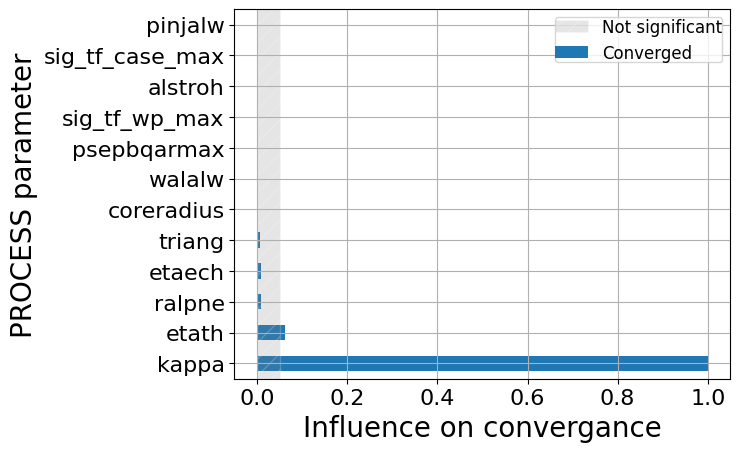

['kappa', 'etath']


In [3]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.05).tolist()
print(significant_conv_vars)

## Find the iteration variables which are influential for the significant convergence variables

In [4]:
rsa_variables = uq_data.itv
significant_itv_list = []
for item in significant_conv_vars:
    rsa_df = uq_data.regional_sensitivity_analysis(figure_of_merit=item,variables_to_sample=rsa_variables, dataframe=uq_data.converged_df, bins=10, confidence_level = 0.30)
    significant_itv_list.extend(rsa_df.index.tolist())
significant_itv_list = list(dict.fromkeys(significant_itv_list))
print("These iteration values drive performance recovery:", significant_itv_list)

KeyError: "['rmajor'] not in index"

## Create a copula based on the important variables for convergence and iteration variables

In [ ]:
copula = Copula(uq_data.converged_df, significant_conv_vars)
copula.calculate_copula(input_sample_size=500,synthetic_sample_size=100000)
copula.calculate_pdf()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)


In [ ]:
itv_vars = significant_conv_vars + significant_itv_list
print(significant_itv_list)
itv_copula = Copula(uq_data.converged_df,itv_vars)
itv_copula.calculate_copula(input_sample_size=500,synthetic_sample_size=100000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()



In [ ]:
custom_data = {"kappa":2.14,"etath":0.41}
sens_plots=InteractivePlot(uq_data,copula,num_intervals=20,custom_data_point=custom_data)
sens_plots.create_layout(significant_conv_vars)

In [ ]:
custom_data={"kappa":1.90,"etath":0.38}
itv_plots=InteractivePlot(uq_data,itv_copula,num_intervals=20,custom_data_point=custom_data)
itv_plots.create_layout(itv_vars,plot_graph=False)